<img src="https://upload.wikimedia.org/wikipedia/commons/thumb/3/39/VU_logo.png/800px-VU_logo.png?20161029201021" width="350">

### Programming large-scale parallel systems

# Matrix-matrix multiplication

## Contents

In this notebook, we will:

- Parallelize a simple algorithm
- Study the performance of different parallelization strategies
- Learn the importance of "grain size" in a parallel algorithm
- Implement and measure the performance of parallel algorithms

<div class="alert alert-block alert-info">
<b>Note:</b> Do not forget to execute the cells below before starting this notebook! 
</div>

In [ ]:
] add BenchmarkTools

In [ ]:
using Distributed
using BenchmarkTools
using Printf
if procs() == workers()
    addprocs(4)
end
function answer_checker(answer,solution)
    if answer == solution
        "🥳 Well done! "
    else
        "It's not correct. Keep trying! 💪"
    end |> println
end
alg_0_comp_check(answer) = answer_checker(answer, "d")
alg_1_deps_check(answer) = answer_checker(answer,"b")
alg_1_comm_overhead_check(answer) = answer_checker(answer, "b")
alg_1_comp_check(answer) = answer_checker(answer, "b")
alg_2_complex_check(answer) = answer_checker(answer, "b")
alg_2_deps_check(answer) = answer_checker(answer,"d")
alg_3_deps_check(answer) = answer_checker(answer, "c")
alg_3_complex_check(answer) = answer_checker(answer, "b")
println("🥳 Well done! ")

## Problem Statement

We consider matrix-matrix multiplication as our first algorithm to parallelize. The problem we want so solve is defined as follows.

Given $A$ and $B$ two $N$-by-$N$ matrices, compute the matrix-matrix product $C=AB$. Compute it in parallel and efficiently.

 <div>
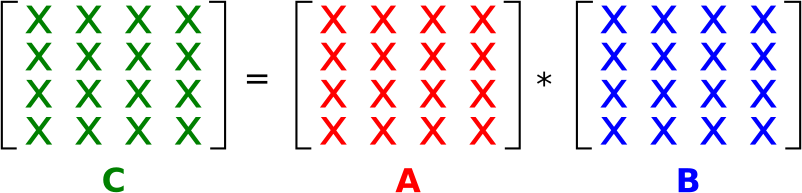
</div>


### Goals

We want to

- compute the product in parallel using more than one process (distributed implementation)
- study the performance of different parallelization alternatives
- implement the algorithms using Julia's task-based programming model


### Assumptions

- All matrices `A`,`B`, and `C` are initially stored in the master process
- The result will be overwritten in `C` (in the master process)

 <div>
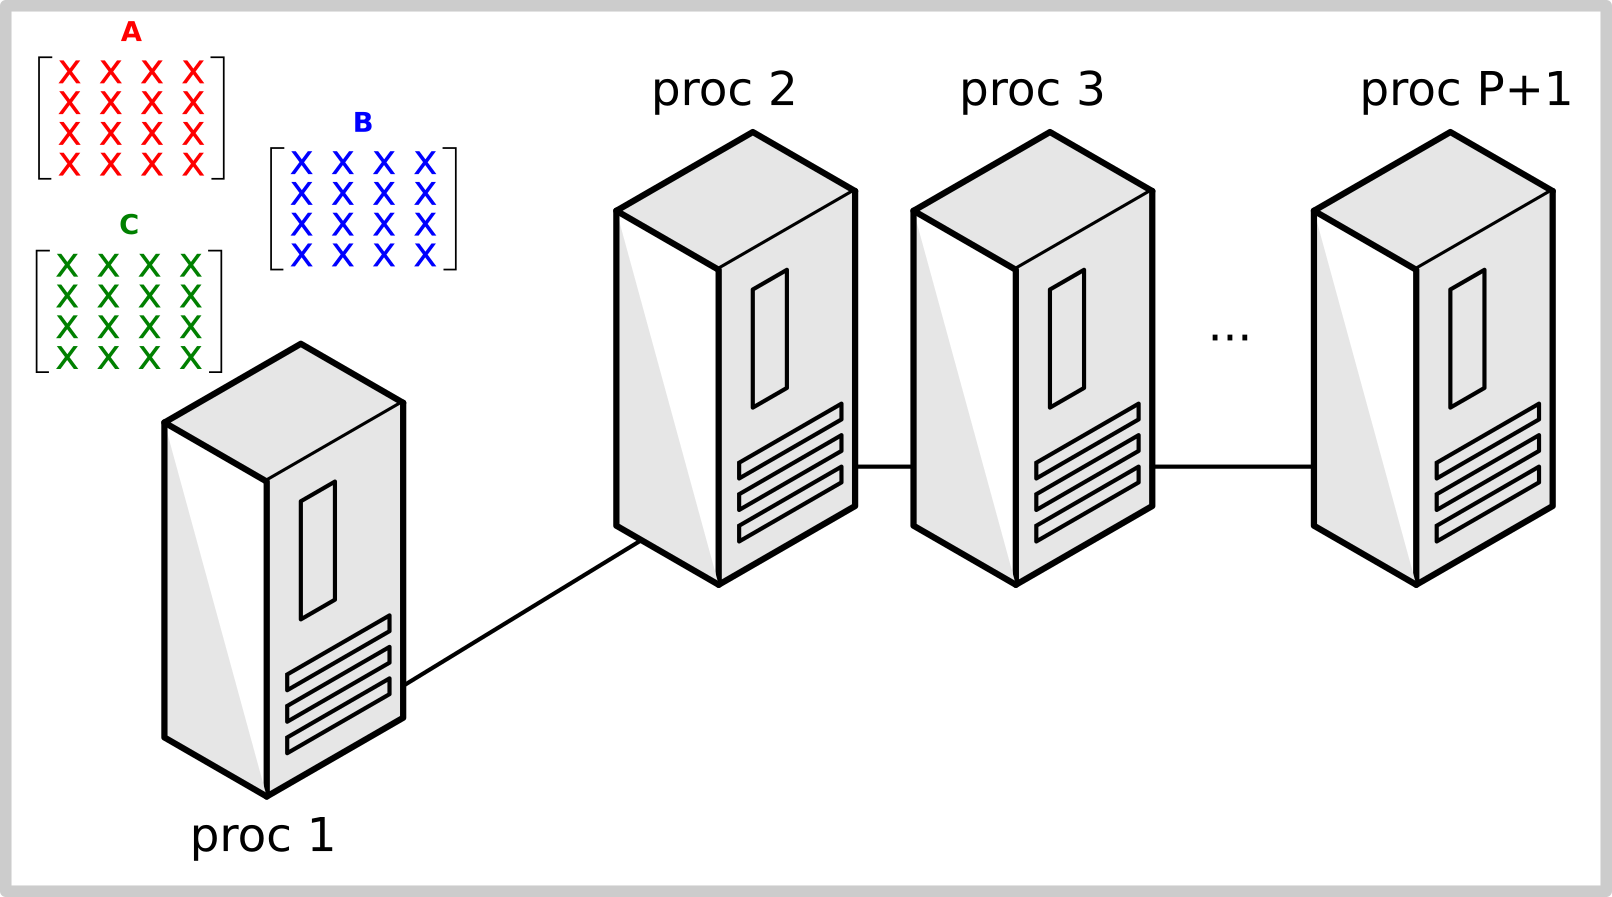
</div>


### Steps

To develop and study the parallel implementation, we will follow these steps:

- Identify the parts of the sequential algorithm that can be parallelized
- Consider different parallelization strategies
- Discuss the (theoretical) performance of these implementations
- Measure the actual performance of these implementations


## Serial implementation

We start by considering the (naive) sequential algorithm, which is based on the math definition of the matrix-matrix product $C_{ij} = \sum_k A_{ik} B_{kj}$

In [ ]:
@everywhere function matmul_seq!(C,A,B)
    m = size(C,1)
    n = size(C,2)
    l = size(A,2)
    @assert size(A,1) == m
    @assert size(B,2) == n
    @assert size(B,1) == l
    z = zero(eltype(C))
    for j in 1:n
        for i in 1:m
            Cij = z
            for k in 1:l
                @inbounds Cij += A[i,k]*B[k,j]
            end
            C[i,j] = Cij
        end
    end
    C
end

Run next cell to test the implementation.

In [ ]:
using Test
N = 10
A = rand(N,N)
B = rand(N,N)
C = similar(A)
matmul_seq!(C,A,B)
@test C ≈ A*B

<div class="alert alert-block alert-info">
<b>Note:</b> The matrix-matrix multiplication naively implemented with 3 nested loops as above is known to be very inefficient (memory bound). Libraries such as BLAS provide much more efficient implementations, which are the ones used in practice (e.g., by the `*` operator in Julia). We consider our hand-written implementation as a simple way of expressing the algorithm we are interested in.
</div>

Just to satisfy your curiosity, run the following cell to compare the performance of our hand-written function with respect to the built in function `mul!`.


In [ ]:
using LinearAlgebra
N = 1000
A = rand(N,N)
B = rand(N,N)
C = rand(N,N)
@btime matmul_seq!(C,A,B)
@btime mul!(C,A,B);

<div class="alert alert-block alert-success">
<b>Question:</b>  Which is the complexity (number of operations) of the serial algorithm? Assume that all matrices are $N$-by-$N$ matrices.    
</div>

    a) O(1)
    b) O(N)
    c) O(N²)
    d) O(N³)

In [ ]:
answer = "x" # replace x with a, b, c, or d 
alg_0_comp_check(answer)

## Where can we exploit parallelism?


The matrix-matrix multiplication is an example of [embarrassingly parallel algorithm](https://en.wikipedia.org/wiki/Embarrassingly_parallel). An embarrassingly parallel (also known as trivially parallel) algorithm is an algorithm that can be split in parallel tasks with no (or very few) dependences between them. Such algorithms are typically easy to parallelize.

Which parts of an algorithm are completely independent and thus trivially parallel? To answer this question, it is useful to inspect the for loops, which are potential sources of parallelism. If the iterations are independent of each other, then they are trivial to parallelize. An easy check to find out if the iterations are dependent or not is to change their order (for instance changing `for j in 1:n` by `for j in n:-1:1`, i.e. doing the loop in reverse). If the result changes, then the iterations are not independent.

Look at the three nested loops in the sequential implementation of the matrix-matrix product:

```julia
for j in 1:n
    for i in 1:m
        Cij = z
        for k in 1:l
            @inbounds Cij +=  A[i,k]*B[k,j]
        end
        C[i,j] = Cij
    end
end
```

Note that:

- Loops over `i` and `j` are trivially parallel.
- The loop over `k` is not trivially parallel. The accumulation into the reduction variable `Cij` introduces extra dependences. In addition, remember that the addition of floating point numbers is not strictly associative due to rounding errors. Thus, the result of this loop may change with the loop order when using floating point numbers. In any case, this loop can also be parallelized, but it requires a parallel *fold* or a parallel *reduction*.



### Parallel algorithms

The loops over `i` and `j` are trivially parallel implies that all the entries of matrix C can be potentially computed in parallel. However, *which it the most efficient solution to solve all these entries in parallel in a distributed system?* To find this we will consider different parallelization strategies:

- Algorithm 1: each worker computes a single entry of C
- Algorithm 2: each worker computes a single row of C
- Algorithm 3: each worker computes N/P rows of C

 <div>
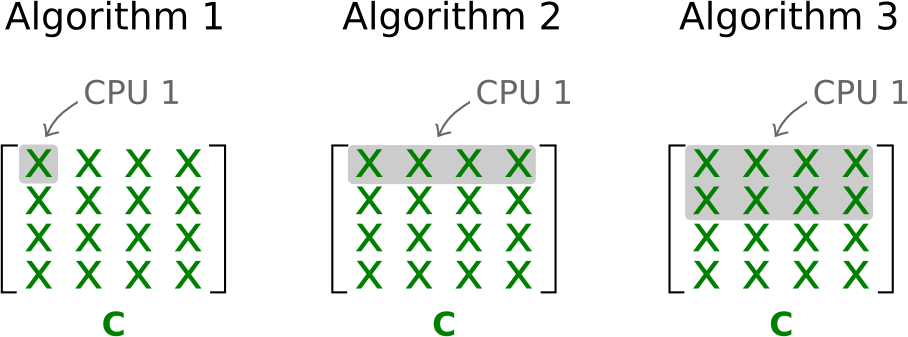
</div>


## Parallel algorithm 1

### Data dependencies

Moving data through the network is expensive and reducing data movement is one of the key points to design efficient distributed algorithms. To this end, we need to determine which is the minimum data needed by a worker to perform its computations. These are called the *data dependencies*. This will give us later information about the performance of the parallel algorithm.

In algorithm 1, each worker computes only an entry of the result matrix C.

 <div>
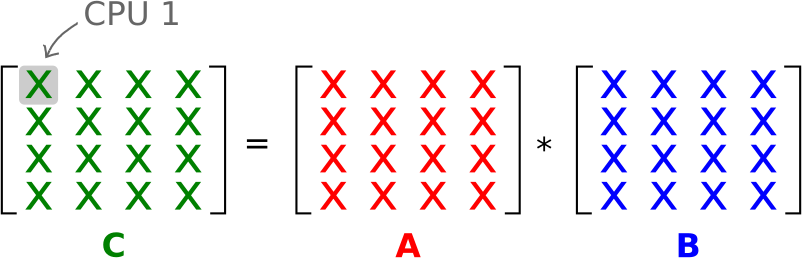
</div>

<div class="alert alert-block alert-success">
<b>Question:</b>  Which are the data dependencies of the computations done by the worker in charge of computing entry C[i,j] ?    
</div>

    a) column A[:,i] and row B[j,:]
    b) row A[i,:] and column B[:,j]
    c) the whole matrices A and B
    d) row A[i,:] and the whole matrix B

In [ ]:
answer = "x" # replace x with a, b, c, or d 
alg_1_deps_check(answer)

### Implementation

Taking into account the data dependencies, the parallel algorithm 1 can be efficiently implemented following these steps from the worker perspective:

1. The worker receives the data dependencies, i.e., the corresponding row A[i,:] and column B[:,j] from the master process
2. The worker computes the dot product of A[i,:] and B[:,j] locally
3. The worker sends back the result of C[i,j] to the master process

 <div>
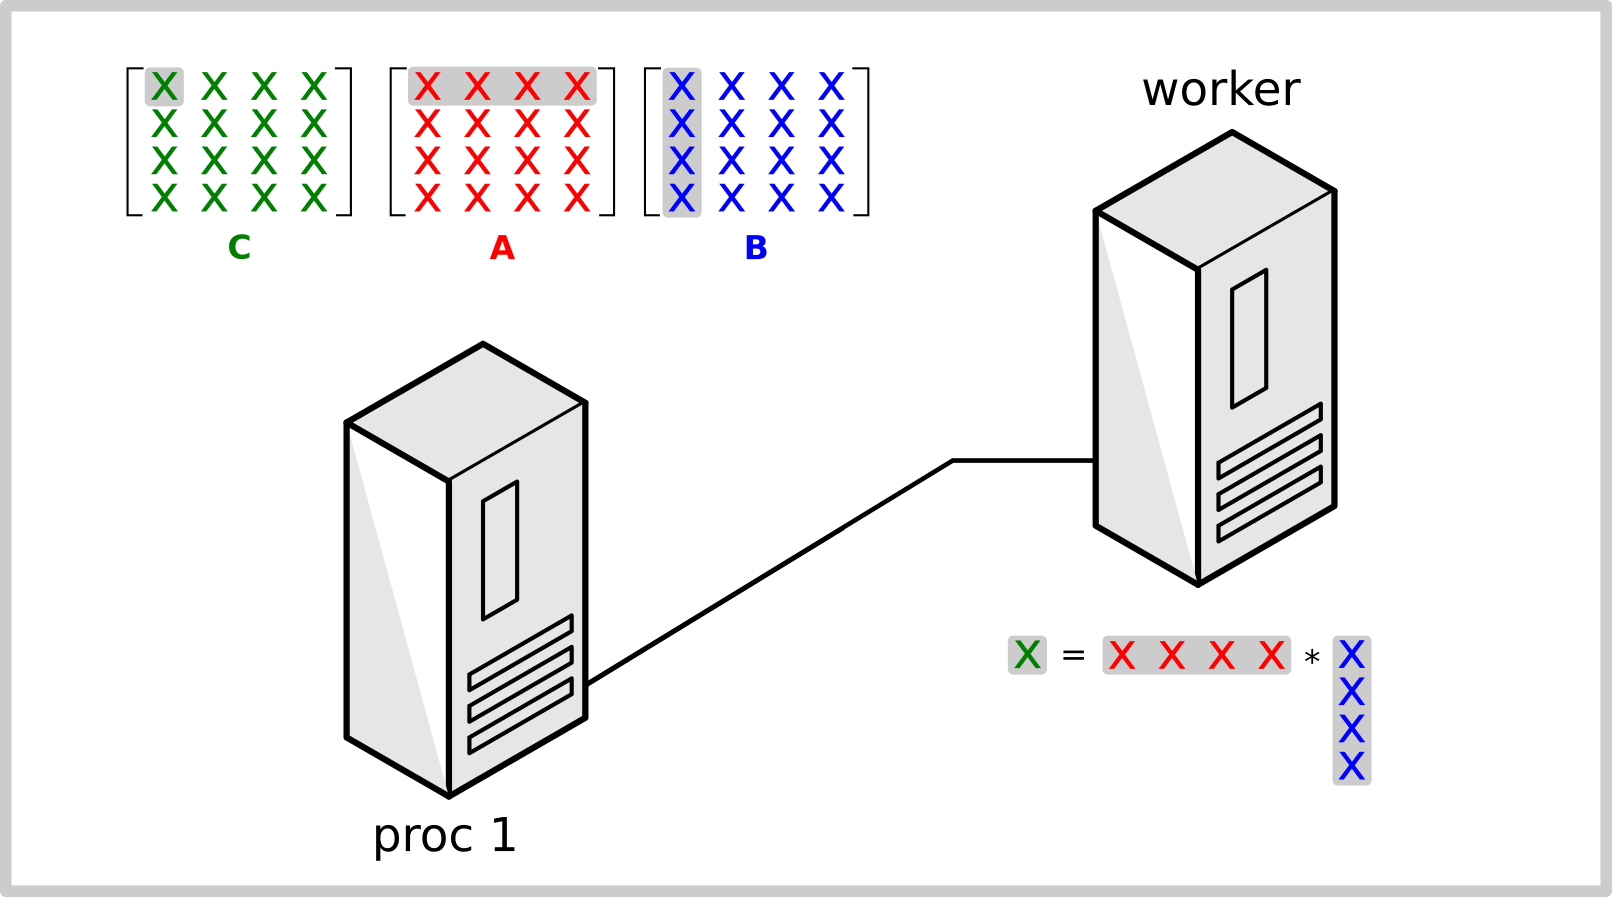
</div>



A possible implementation of this algorithm in Julia is as follows. Try to understand why `@sync` and `@async` are needed here.

In [ ]:
function matmul_dist_1!(C, A, B)
    m = size(C,1)
    n = size(C,2)
    l = size(A,2)
    @assert size(A,1) == m
    @assert size(B,2) == n
    @assert size(B,1) == l
    z = zero(eltype(C))
    @assert nworkers() == m*n
    iw = 0    
    @sync for j in 1:n
        for i in 1:m
            Ai = A[i,:]
            Bj = B[:,j]
            iw += 1
            w = workers()[iw]
            ftr = @spawnat w begin
                Cij = z
                for k in 1:l
                    @inbounds Cij += Ai[k]*Bj[k]
                end
                Cij
            end
            @async C[i,j] = fetch(ftr)
        end
    end
    C
end

You can execute the following cells to test this implementation.

In [ ]:
using Test
N = 2
A = rand(N,N)
B = rand(N,N)
C = similar(A)
matmul_dist_1!(C,A,B)
@test  C ≈ A*B

### Performance

We have a first parallel algorithm, but how efficient is this algorithm? Let us study its performance. To this end we need to consider a performance baseline as reference. In this case, we will use the so-called optimal parallel *speedup*. The parallel speedup on $P$ processes is defined as  

$$
S_P = \frac{T_1}{T_P},
$$

where $T_1$ denotes the runtime of the sequential algorithm and $T_P$ denotes the runtime of the parallel algorithm on $P$ processes. If we run an optimal parallel algorithm with $P$ processes we expect it to run $p$ times faster than the sequential implementation. I.e., the *optimal* speedup of a parallel algorithm on $p$ processes is equal to $P$:

$$
S^{*}_p = P.
$$

The ratio of the actual speedup over the optimal one is called the parallel efficiency (the closer to one the better).

$$
E_p = \frac{S_p}{S^{*}_p} = \frac{T_1/T_P}{P}.
$$



### Experimental speedup

The following cell measures the speedup of parallel algorithm 1. Do we achieve the optimal speedup?

In [ ]:
N = 2
A = rand(N,N)
B = rand(N,N)
C = similar(A)
T1 = @belapsed matmul_seq!(C,A,B)
C = similar(A)
TP = @belapsed matmul_dist_1!(C,A,B)
P = nworkers()
println("Speedup = ", T1/TP)
println("Optimal speedup = ", P)
println("Efficiency = ", 100*(T1/TP)/P, "%")

### Communication overhead

Since communication is usually the main bottleneck in a distributed algorithm, we want to reduce the amount of communication per unit of computation in a worker. Let us compute the (theoretical) communication overhead for algorithm 1. This will help us understand why the speedup of this algorithm was so bad.

Remember, algorithm 1 consisted of these main steps:

1. The worker receives the corresponding row A[i,:] and column B[:,j] from the master process
2. The worker computes the dot product of A[i,:] and B[:,j]
3. The worker sends back the result of C[i,j] to the master process

<div class="alert alert-block alert-success">
<b>Question:</b>  How many scalars are communicated from and to a worker?  Assume that matrices A, B, and C are N by N matrices.
</div>

    a) O(1)
    b) O(N)
    c) O(N²)
    d) O(N³)

In [ ]:
answer = "x" # replace x with a, b, c, or d 
alg_1_comm_overhead_check(answer)

<div class="alert alert-block alert-success">
<b>Question:</b>  How many operations are done in a worker?    
</div>

    a) O(1)
    b) O(N)
    c) O(N²)
    d) O(N³)

In [ ]:
answer = "x" # replace x with a, b, or c
alg_1_comp_check(answer)

From these results we can conclude:

- The communication complexity is O(N)
- The computation complexity is O(N)
- The ratio communication over computation (the communication overhead) is O(1)

In other words, the communication cost is of the same order of magnitude as the computation cost. Since, communication is orders of magnitude slower in real systems, the runtime in the worker will be dominated by communication. This explains why we obtained such a bad speedup.


## Parallel algorithm 2

Let us study the next algorithm to see if we can improve the efficiency by augmenting the granularity (i.e. the amount of work) in each parallel task. In parallel algorithm 2, each worker computes an entire row of C.







<div>
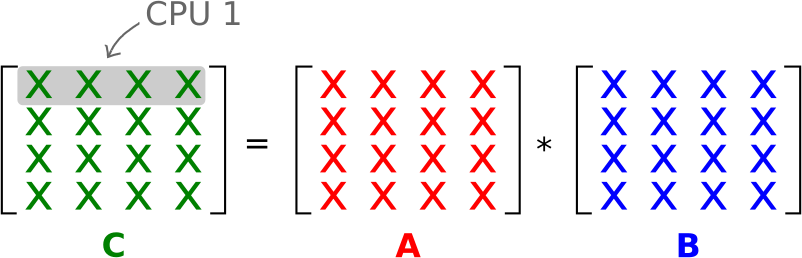
</div>

### Data dependencies

<div class="alert alert-block alert-success">
<b>Question:</b>  Which are the data dependencies of the computations done by the worker in charge of computing row C[i,:] ?    
</div>

    a) column A[:,i] and row B[j,:]
    b) row A[i,:] and column B[:,j]
    c) the whole matrices A and B
    d) row A[i,:] and the whole matrix B

In [ ]:
answer = "x" # replace x with a, b, c, or d 
alg_2_deps_check(answer)

### Implementation

These are the main steps of the implementation of algorithm 2:

1. The worker receives the corresponding row A[i,:] and matrix B from the master process
2. The worker computes the product of row A[i,:] times B
3. The worker sends back the result of row C[i,:] to the master process




<div>
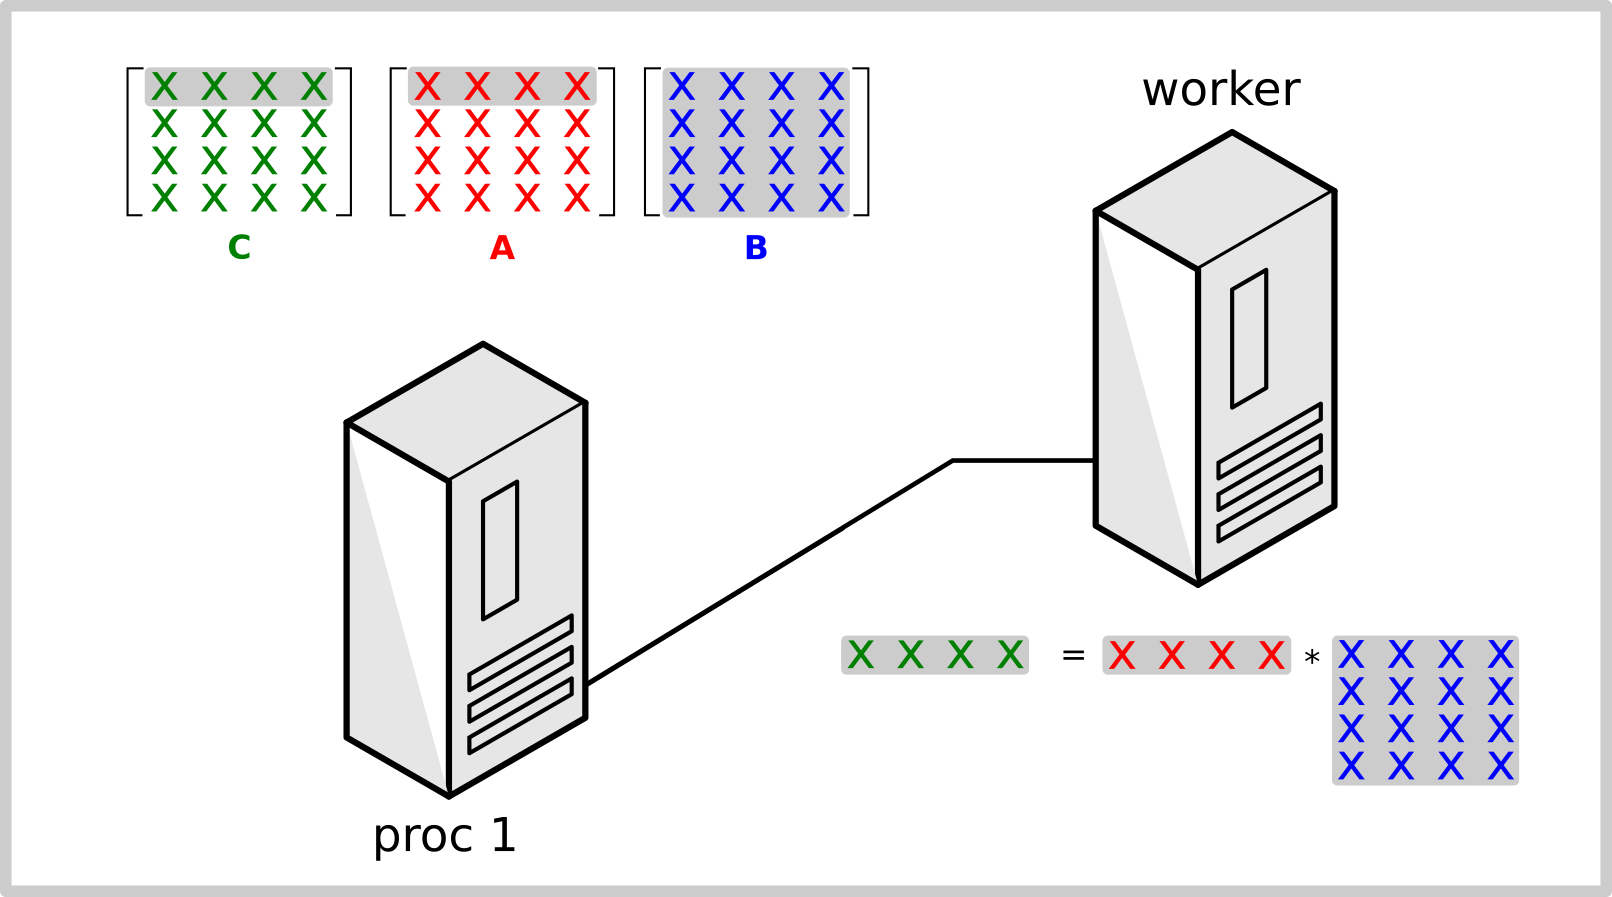
</div>


A possible implementation of this algorithm in Julia is as follows:

In [ ]:
function matmul_dist_2!(C, A, B)
    m = size(C,1)
    n = size(C,2)
    l = size(A,2)
    @assert size(A,1) == m
    @assert size(B,2) == n
    @assert size(B,1) == l
    z = zero(eltype(C))
    @assert nworkers() == m
    iw = 0
    @sync for i in 1:m
        Ai = A[i,:]
        iw += 1
        w = workers()[iw]
        ftr = @spawnat w begin
            Ci = fill(z,n)
            for j in 1:n
                for k in 1:l
                    @inbounds Ci[j] += Ai[k]*B[k,j]
                end
            end
            Ci
        end
        @async C[i,:] = fetch(ftr)
    end
    C
    end

Test it using next cell

In [ ]:
using Test
N = 4
A = rand(N,N)
B = rand(N,N)
C = similar(A)
@test matmul_dist_2!(C,A,B) ≈ A*B

### Experimental speedup

Measure the speedup with the following cell. Is this time better?

In [ ]:
N = 4
A = rand(N,N)
B = rand(N,N)
C = similar(A)
T1 = @belapsed matmul_seq!(C,A,B)
C = similar(A)
TP = @belapsed matmul_dist_2!(C,A,B)
P = nworkers()
println("Speedup = ", T1/TP)
println("Optimal speedup = ", P)
println("Efficiency = ", 100*(T1/TP)/P, "%")

### Complexity

The speedup is still far from the optimal one. Let us study the communication overhead for this algorithm. Remember, algorithm 2 consists in these main steps:

1. The worker receives the corresponding row A[i,:] and matrix B from the master process
2. The worker computes the product of row A[i,:] times B
3. The worker sends back the result of row C[i,:] to the master process

<div class="alert alert-block alert-success">
<b>Question:</b>  Which is the complexity of the communication and computations done by a worker in algorithm 2?
</div>

    a) O(N) communication and O(N^2) computation
    b) O(N^2) communication and O(N^2) computation
    c) O(N^3) communication and O(N^3) computation
    d) O(N) communication and O(N) computation

In [ ]:
answer = "x" # replace x with a, b, c, or d 
alg_2_complex_check(answer)

The communication and computation cost are still of the same order of magnitude even though we have increased the grain size. 

## Parallel algorithm 3

Let us increase even more the granularity of the parallel tasks by computing several rows of C in a worker.  Each worker computes N/P consecutive rows of C, where P is the number of workers.


<div>
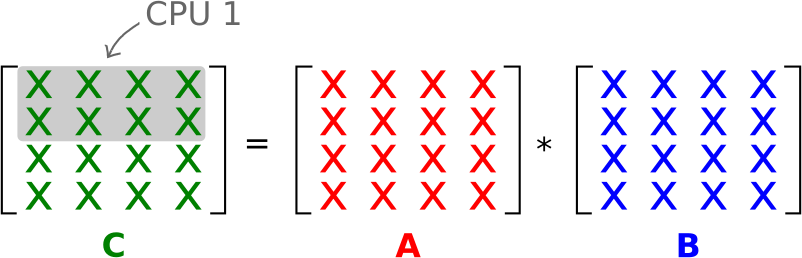
</div>

### Data dependencies

<div class="alert alert-block alert-success">
<b>Question:</b>  Which are the data dependencies of the computations done by the worker in charge of computing the range of rows C[rows,:] ?  
</div>


    a) A[rows,:] and B[:,rows] 
    b) the whole matrix A and B[:,rows]
    c) A[rows,:] and the whole matrix B
    d) the whole matrices A and B

In [ ]:
answer = "x" # replace x with a, b, c, or d 
alg_3_deps_check(answer)

### Implementation

These are the main steps of the implementation of algorithm 3:

1. The worker receives the corresponding rows A[rows,:] and matrix B from the master process
2. The worker computes the product of A[rows,:] times B
3. The worker sends back the result of C[rows,:] to the master process

<div>
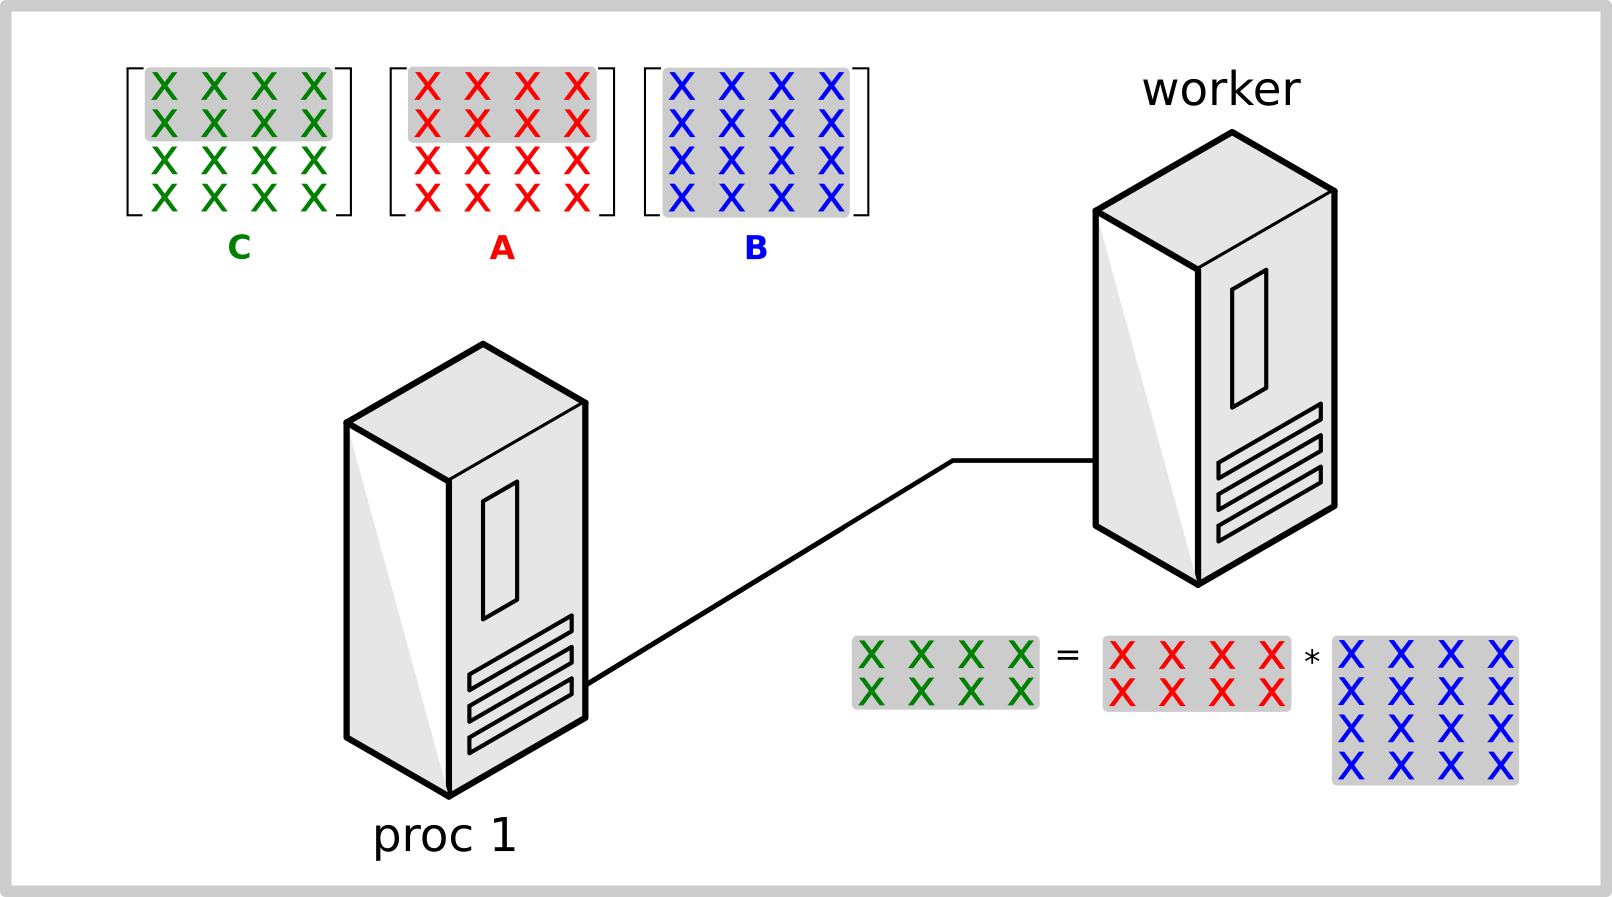
</div>

The implementation of this variant is let as an exercise (see below).

### Communication overhead

Let us analyze the (theoretical) communication overhead for algorithm 3.

<div class="alert alert-block alert-success">
<b>Question:</b>  Which is the complexity of the communication and computations done by a worker in algorithm 3?
</div>

    a) O(N²) communication and O(N³) computation
    b) O(N²) communication and O(N³/P) computation
    c) O(N²) communication and O(N²) computation
    d) O(N²/P) communication and O(N³/P) computation

In [ ]:
answer = "x" # replace x with a, b, c, or d 
alg_3_complex_check(answer)

In this case, the ratio between communication and computation is O(P/N). If the matrix size N is much larger than the number of workers P, then the communication overhead O(P/N) would be negligible. This opens the door to an scalable implementation.

## Summary

The table below compares the three parallel algorithms. 

<div id = "div1"></div>

| Algorithm | Parallelism <br>(#workers) | Communication <br>per worker | Computation <br>per worker | Ratio communication/<br>computation |
|---|---|---|---|---|
| 1 | N² | O(N) | O(N) | O(1) |
| 2 | N | O(N²) | O(N²) | O(1) |
| 3 | P | O(N²) | O(N³/P) | O(P/N) |


- Matrix-matrix multiplication is trivially parallelizable (all entries in the result matrix can be computed in parallel, at least in theory)
- However, we cannot exploit all the potential parallelism in a distributed system due to communication overhead
- We need a sufficiently large grain size to obtain a near optimal speedup
- We measured the theoretical parallel performance by computing the complexity of communication over computation
- We measured the actual performance using the parallel speedup and parallel efficiency


## Exercises

### Exercise 1

Implement algorithm 3 in the function below. For simplicity, assume that the number of rows of C is a multiple of the number of workers.


In [ ]:
function matmul_dist_3!(C,A,B)
    m = size(C,1)
    n = size(C,2)
    l = size(A,2)
    @assert size(A,1) == m
    @assert size(B,2) == n
    @assert size(B,1) == l
    @assert mod(m,nworkers()) == 0
    # Implement here
    
    C
end

Use test-driven development to implement the algorithm. Use this test:

In [ ]:
using Test
P = nworkers()
load = 100
N = load*P
A = rand(N,N)
B = rand(N,N)
C = similar(A)
@test matmul_dist_3!(C,A,B) ≈ A*B

Measure the performance of your implementation by running next cell. Do you get close to the optimal speedup?

In [ ]:
P = nworkers()
load = 100
N = load*P
A = rand(N,N)
B = rand(N,N)
C = similar(A)
T1 = @belapsed matmul_seq!(C,A,B)
C = similar(A)
TP = @belapsed matmul_dist_3!(C,A,B)
println("Speedup = ", T1/TP)
println("Optimal speedup = ", P)
println("Efficiency = ", 100*(T1/TP)/P, "%")

# License


This notebook is part of the course [Programming Large Scale Parallel Systems](https://www.francescverdugo.com/XM_40017/dev/) at Vrije Universiteit Amsterdam and may be used under a [CC BY 4.0](https://creativecommons.org/licenses/by/4.0/) license.